# Data downloaded from [here](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation)

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes.

Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1).

# IMPORTANT: Apparently training data 355's segmentation file is named incorrectly in the original dataset; manual renaming to the correct naming convention is required to prevent errors 
### Alternatively, skip 355 by uncommenting the appropriate line of code under the "Preprocessing" section

### Code referenced from [this kaggle notebook](https://www.kaggle.com/code/polomarco/brats20-3dunet-3dautoencoder/data)



In [2]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


import albumentations as A
from albumentations import Compose

import warnings
warnings.simplefilter("ignore")

In [3]:
# Global config class
class GlobalConfig:
    # Global config class
    root_dir = './BraTS2020'
    train_root_dir = './BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = './BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    # CSV where patient ID, path and fold information will be stored
    path_to_csv = './train_data.csv'
    # Where your pretrained model is stored (Specifically for the 3DUnet architecture implemented here)
    pretrained_model_path = './BraTS2020Logs/model_by_original_notebook_author.pth'
    # Where train log is stored; each row (epoch) consists of train/val loss, dice score and jaccard score.  
    train_logs_path = './BraTS2020Logs3DUnetBCEDice' #TO DO: Change this for changes in different hyperparam/Model 
    # for reproducibility
    seed = 42


def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def load_img(file_path):
    data = nib.load(file_path)
    data = np.asarray(data.dataobj)
    return data

config = GlobalConfig()
seed_everything(config.seed)
if not os.path.isdir(config.train_logs_path):
    os.mkdir(config.train_logs_path)


# Visualisations

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)
mask unique -> [0 1 2 4]


Text(0.5, 0.98, 'Multimodal Scans -  Data | Manually-segmented mask - Target')

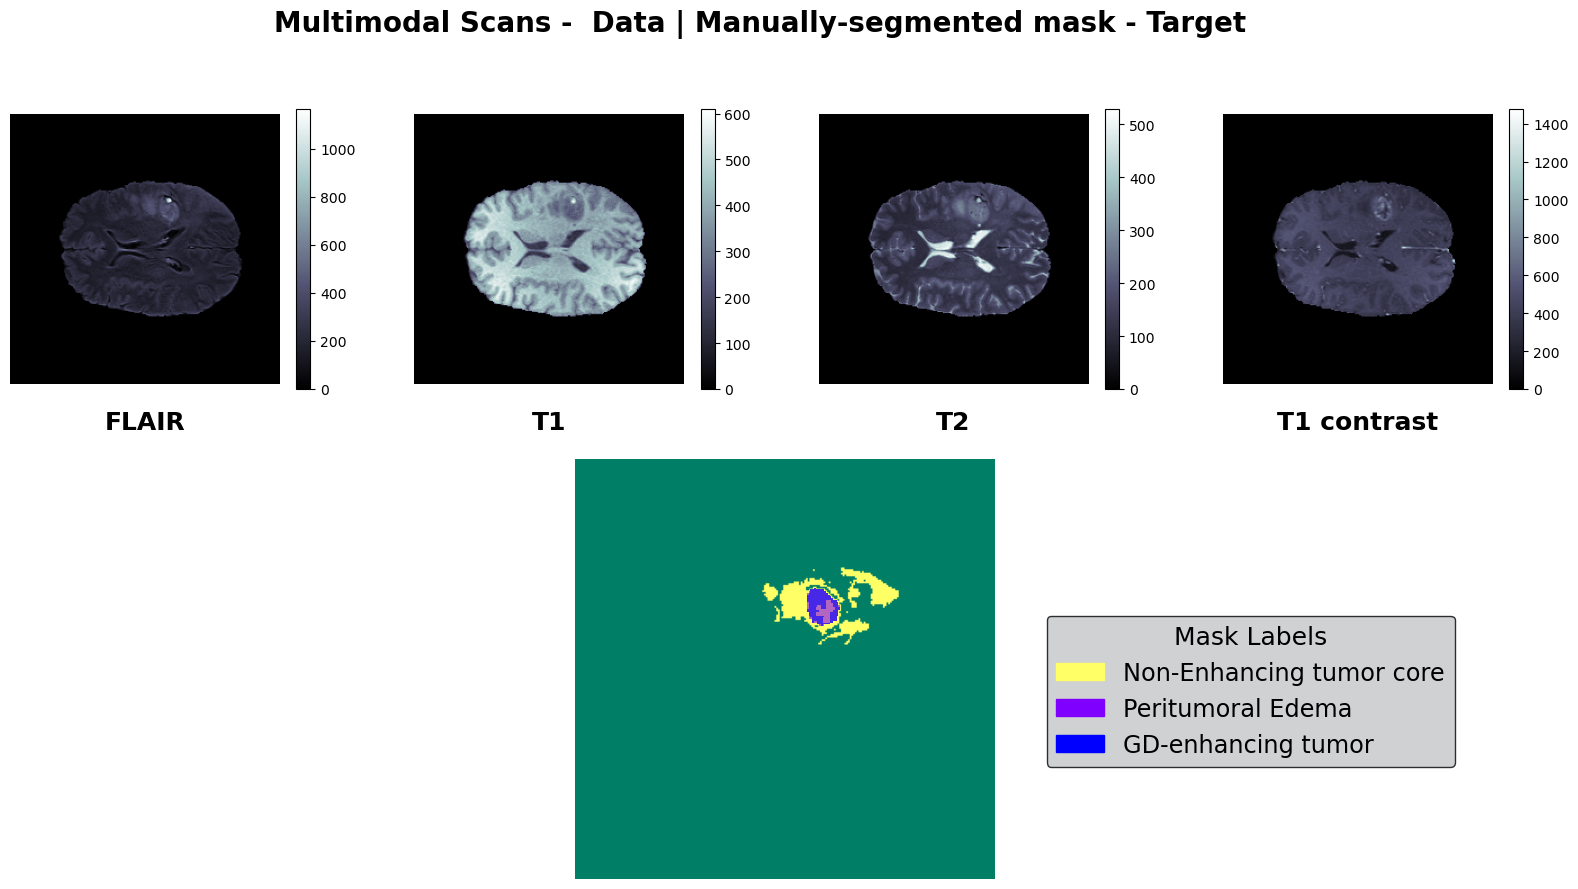

In [4]:
# Change these to visualise brain MRIs of different patients, and at different slices 
PATIENT_IDX = 10 # 1 - 369
SLICE_IDX = 85 # 0 - 154


sample_filename = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_flair.nii"
sample_filename_mask = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_seg.nii"

sample_img = load_img(sample_filename)
sample_mask = load_img(sample_filename_mask)

sample_filename2 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1.nii"
sample_img2 = load_img(sample_filename2)

sample_filename3 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t2.nii"
sample_img3 = load_img(sample_filename3)

sample_filename4 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1ce.nii"
sample_img4 = load_img(sample_filename4)

# (240, 240, 155), corresponding to height, width and depth
print("img shape ->", sample_img.shape)  
print("mask shape ->", sample_mask.shape) 
# [0,1,2,4], corresponding to the background (BG — label 0), necrotic and non-enhancing tumor core (NCR/NET — label 1), the peritumoral edema (ED — label 2) and GD-enhancing tumor (ET — label 4)
print("mask unique ->", np.unique(sample_mask)) 

# In the BraTS challenge, the segmentation performance is evaluated on three partially overlapping sub-regions of tumors,
# namely, whole tumor (WT), tumor core (TC), and enhancing tumor (ET).
# The WT is the union of ED, NCR/NET, and ET, while the TC includes NCR/NET and ET.
# We hence create 3 sets of mask. This will eventually be stacked upon each other during preprocessing in the Dataset Class.
mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1


# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib


fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:, :, SLICE_IDX], cmap='bone') # Show all columns and rows, but a specific slice index
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:, :, SLICE_IDX], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:, :, SLICE_IDX], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:, :, SLICE_IDX], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,SLICE_IDX]== False,  mask_WT[:,:,SLICE_IDX]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:, :, SLICE_IDX], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:, :, SLICE_IDX] == False,  mask_TC[:, :, SLICE_IDX]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:, :, SLICE_IDX] == False, mask_ET[:, :, SLICE_IDX]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0, ax1, ax2, ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3]]
labels = ['Non-Enhancing tumor core',
          'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [mpatches.Patch(
    color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize='xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target",
             fontsize=20, weight='bold')

# fig.savefig("data_sample.png", format="png",  pad_inches=0.2,
#             transparent=False, bbox_inches='tight')
# fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2,
#             transparent=False, bbox_inches='tight')


# Preprocessing

### Mapping different patients (and the paths to their data) to different training folds; Fold 0 will be used as validation set; rest will be used as training set

In [9]:
survivalInfoPath = f"{config.train_root_dir}/survival_info.csv"
nameMappingPath = f"{config.train_root_dir}/name_mapping.csv"
survival_info_df = pd.read_csv(survivalInfoPath)
name_mapping_df = pd.read_csv(nameMappingPath)

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")
df = df[["Brats20ID"]]
paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    path = os.path.join(config.train_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

train_data = df

"""Uncomment the following if skipping number 355 due to errors"""
# train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

kf = KFold(n_splits=7, random_state=config.seed, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(train_data)):
    # assign all rows at val_index to the ith fold
    train_data.loc[val_index, "fold"] = i

# Data in folds other than 0 are used for training
train_df = train_data.loc[~train_data['fold'].isin([0, 1])].reset_index(drop=True)
# Data in fold 0 is used for validation
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)
test_df = train_data.loc[train_data['fold'] == 1].reset_index(drop=True)

print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv(config.path_to_csv, index=False)


train_df -> (263, 3) val_df -> (53, 3) test_df -> (53, 3)


In [10]:
train_df


,Brats20ID,path,fold
0,BraTS20_Training_002,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,5.0
1,BraTS20_Training_003,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,3.0
2,BraTS20_Training_005,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,4.0
3,BraTS20_Training_007,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,2.0
4,BraTS20_Training_009,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,5.0
...,...,...,...
258,BraTS20_Training_363,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,6.0
259,BraTS20_Training_364,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,3.0
260,BraTS20_Training_365,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,2.0
261,BraTS20_Training_367,./BraTS2020/BraTS2020_TrainingData/MICCAI_BraT...,6.0


# Dataset DataLoader

### TO-DO: Try different data augmentation techniques

In [7]:

class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", do_resizing: bool=False):
        # Dataframe containing patient, path and fold mapping information
        self.df = df
        # "train", "valid" or "test". Determines whether to apply preprocessing
        self.phase = phase
        self.augmentations = self.get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.do_resizing = do_resizing
        
    def __len__(self): 
        return self.df.shape[0]
    
    def __getitem__(self, idx): # Makes class accessible by square-bracket notations; determines behaviour upon square-bracket access
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        images = []
        # load all modalities(t1, t1ce, t2, flair)
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)
            
            if self.do_resizing:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
        # stack all 4 modalities into single array as model input
        img = np.stack(images)
        # move axes of array to new position; 
        # original shape - (4,240,240,155) -> (4,155,240,240) - new shape; facilitates input into 3DUnet model
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            
            if self.do_resizing:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            # Creates and stacks appropriate (possibly overlapping) masks as per BraTS challenge. More info in function.
            mask = self.preprocess_mask_labels(mask)
    
            # Peform augmentations
            augmented = self.augmentations(image=img.astype(np.float32), mask=mask.astype(np.float32))
            img = augmented['image']
            mask = augmented['mask']
    
            # Returns dictionary with Id, image (x) and mask (y) in train/val phase, else return only id and image (x) in test phase
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        
        return {
            "Id": id_,
            "image": img,
        }

    # TO-DO: Implement possible augmentations here? Lower priority for now
    def get_augmentations(self, phase):
        list_transforms = []
        list_trfms = Compose(list_transforms)
        return list_trfms
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):
        # In the BraTS challenge, the segmentation performance is evaluated on three partially overlapping sub-regions of tumors,
        # namely, whole tumor (WT), tumor core (TC), and enhancing tumor (ET).
        # The WT is the union of ED, NCR/NET, and ET, while the TC includes NCR/NET and ET.

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

        

In [8]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0, # Choose which fold to be the validation fold
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

In [9]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0, batch_size=1)
len(dataloader)


53

In [10]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape
# size = (batch_size, channels, depth, width, height)

(['BraTS20_Training_016'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

Num uniq Image values : 1313
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([8800811,  127189]))
(155, 240, 240)


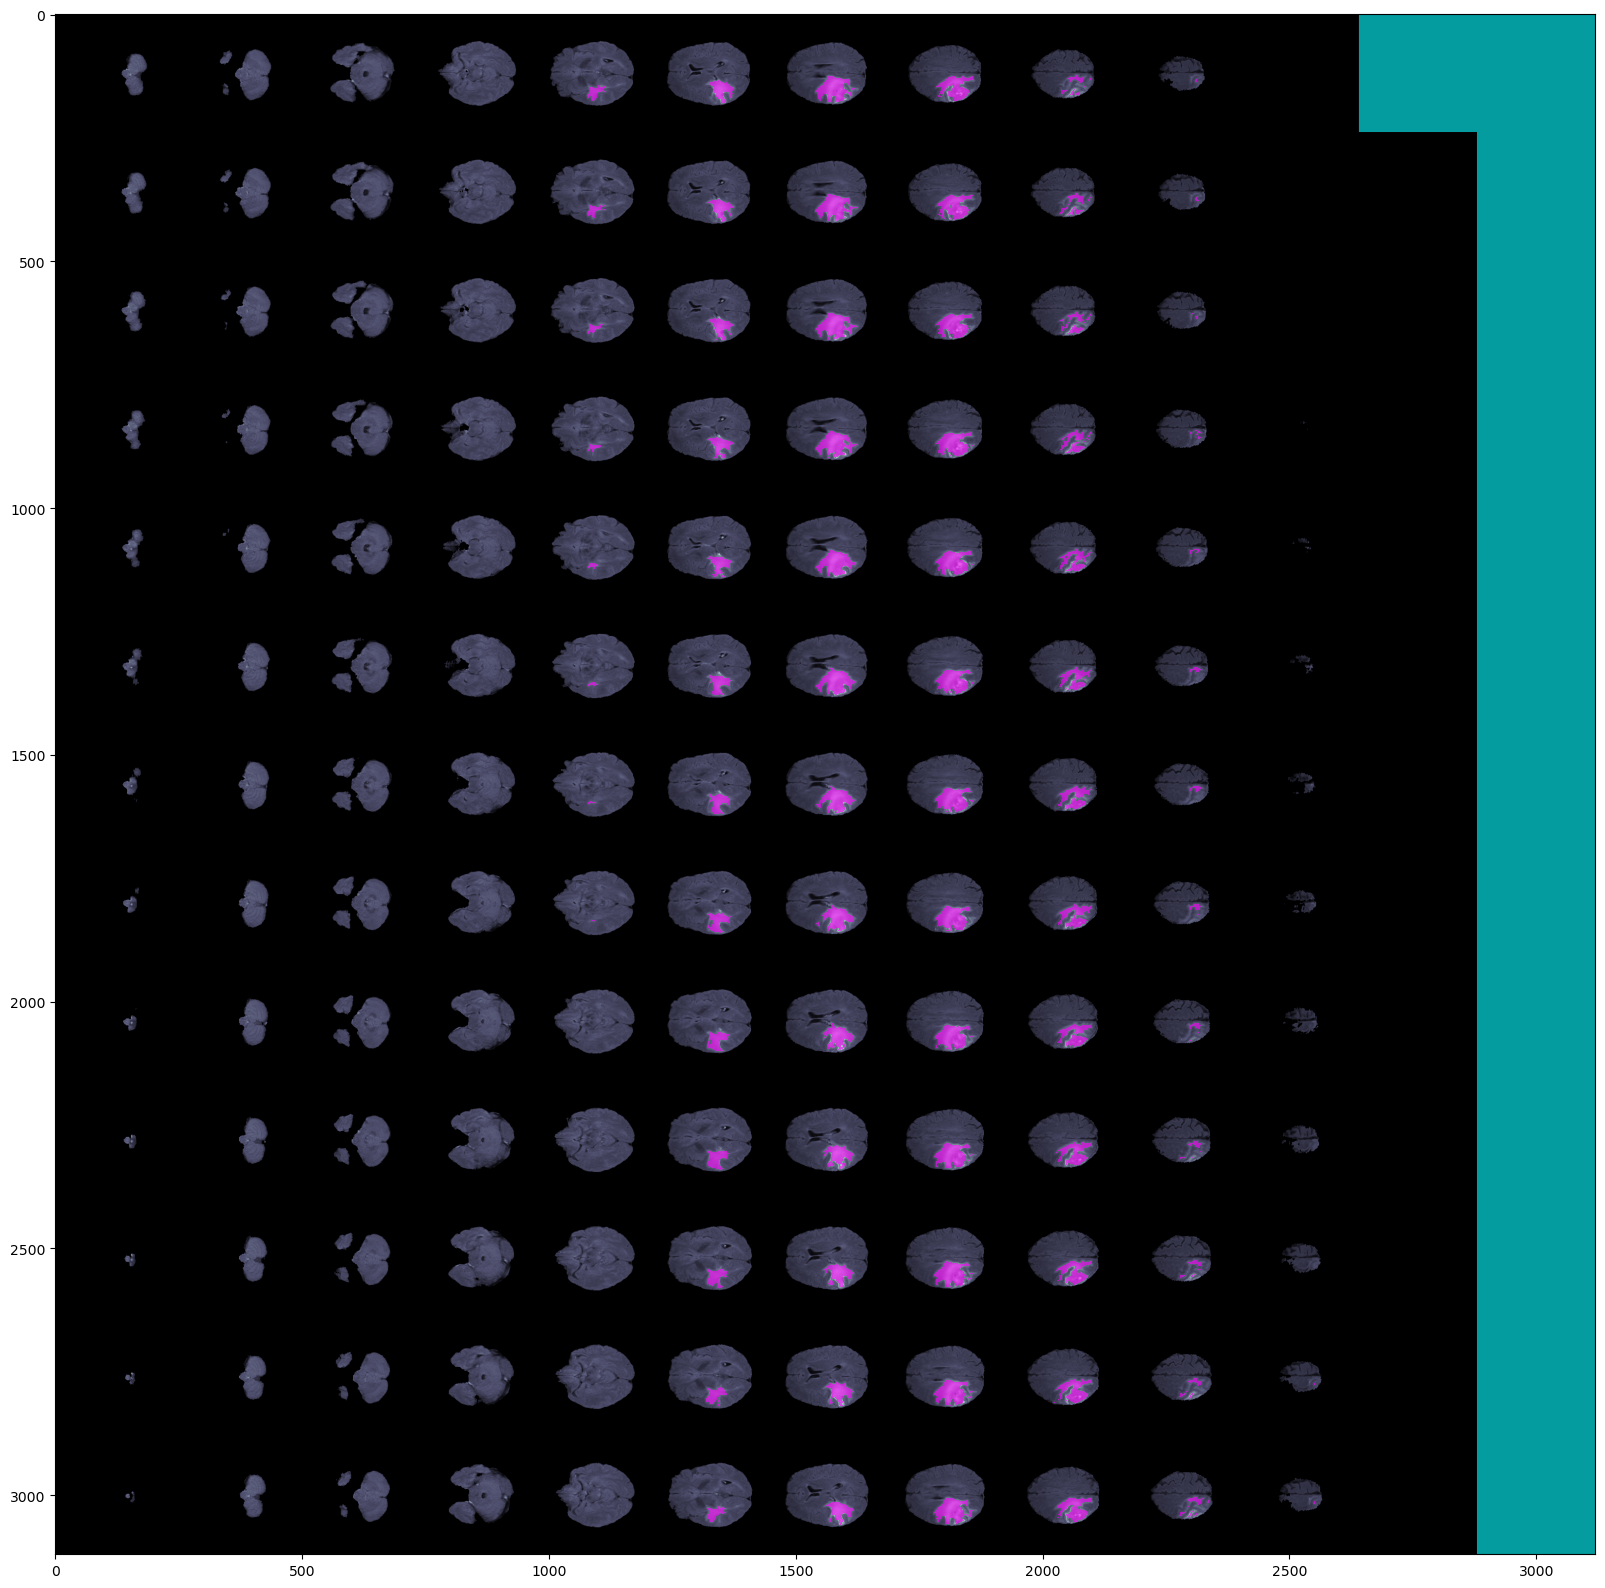

In [11]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))
print(img_tensor.shape)
image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

# Metric and Loss

In [12]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice Score for data batch.
    2 * the Area of Overlap divided by the total number of pixels in both images
    Also known as F1
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Area of Overlap over Area of Union
    Also known as Intersection-Over-Union (IoU) 
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

# Used to accumulate and calculate metrices per epoch
class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# 3DUnet

### TO-DO: Try different model architectures

In [13]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

# Trainer

In [14]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",  # Reduces learning rate when a metric has stopped improving
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        # print(f"{phase} epoch: {epoch + 1} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        t_dataloader = tqdm(enumerate(dataloader), unit="batch", total=total_batches)
        for itr, data_batch in t_dataloader:
            t_dataloader.set_description(f"{phase} epoch: {epoch + 1} | time: {time.strftime('%H:%M:%S')}")
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            t_dataloader.set_postfix(loss=loss.item())
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                now = datetime.now().strftime("%Y%m%d-%H%M%S")
                checkpoint_filename = f"your_best_model_{now}.pth"
                torch.save(self.net.state_dict(), os.path.join(
                    config.train_logs_path, checkpoint_filename))
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        now = datetime.now().strftime("%Y%m%d-%H%M%S")
        checkpoint_filename = f"your_last_epoch_model_{now}.pth"
        torch.save(self.net.state_dict(),os.path.join(
            config.train_logs_path, checkpoint_filename))

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        # train_logs_path = './BraTS2020Logs/train_log.csv'
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv(os.path.join(config.train_logs_path, f"train_log_{now}.csv"), index=False)


# Training

## TO-DO: Train your own model; experiment with different hyperparameters

### **Optional**: If you don't want to train from scratch, download the 3DUnet model checkpoint trained by the author of the [referenced notebook](https://www.kaggle.com/code/polomarco/brats20-3dunet-3dautoencoder/notebook) and place it in the same path as `config.pretrained_model_path`

### Alternatively, train your own model and reload it from the same place.

In [19]:

# n_channels should be in multiples of num_groups (default 8)
model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda')

In [20]:
from torchsummary import summary
# summary(model, (4,155,240,240),1)
print(model)

UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 24, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 24, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 48, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 48, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (enc2): Down(
   

In [ ]:
trainer = Trainer(net=model,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=50,
                  path_to_csv = config.path_to_csv,)

"""UNCOMMENT THE FOLLOWING 2 LINES IF RELOADING MODEL CHECKPOINT"""
# if config.pretrained_model_path is not None:
#     trainer.load_predtrain_model(config.pretrained_model_path)
    
    
    
    
    
    
    
    # if need - load the logs.      
    # train_logs = pd.read_csv(config.train_logs_path)
    # trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    # trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    # trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    # trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    # trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    # trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda


'UNCOMMENT THE FOLLOWING 2 LINES IF RELOADING MODEL CHECKPOINT'

In [ ]:
"""Uncomment these to clear GPU VRAM"""
# del model
# torch.cuda.empty_cache()
# torch.cuda.synchronize()


'Uncomment these to clear GPU VRAM'

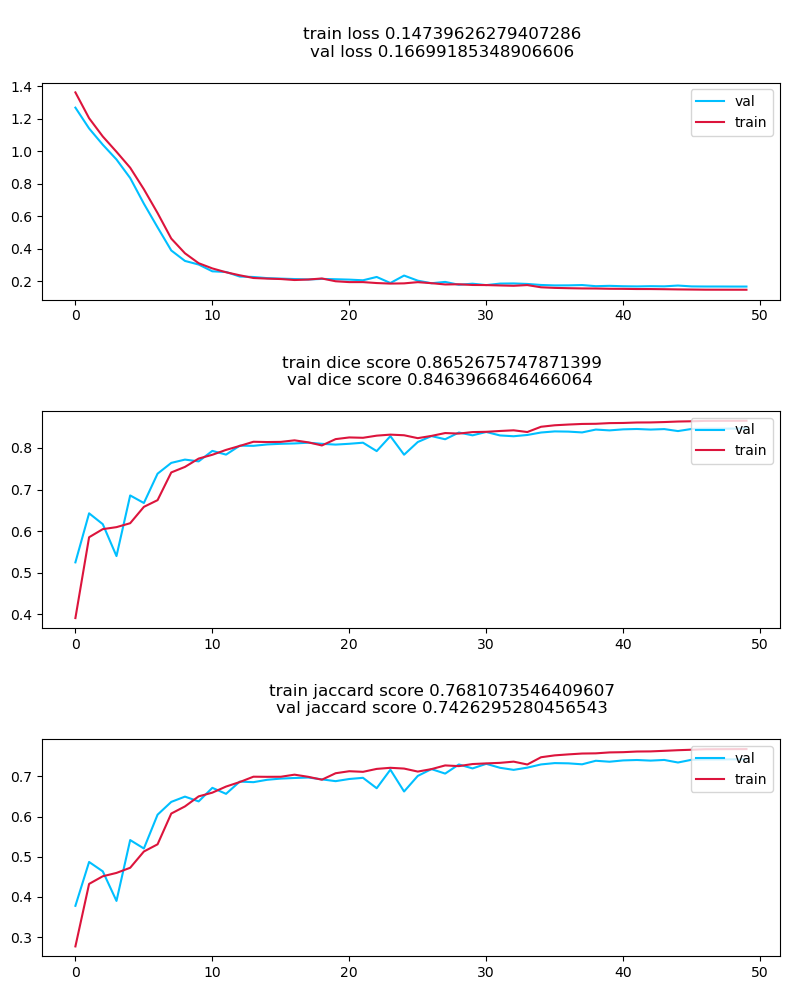


####################
Saved new checkpoint
####################




In [ ]:
# assert(0==1)
"""UNCOMMENT THIS TO START TRAINING"""
trainer.run()

# write logs to train_logs_path
with open(os.path.join(config.train_logs_path, 'train_log.txt'), 'w') as f:
  for param, value in trainer.__dict__.items():
      if not param.startswith("__"):
        f.write(f"{param}:{value}\n")


# Evaluation and Results

In [ ]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes


In [ ]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=1)
len(dataloader)

53

In [ ]:
model.eval()
print()

In [ ]:
# %%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, val_dataloader, ['WT', 'TC', 'ET']
    )

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
19,0.912239,0.838639,0.849059,0.737709,0.681884,0.517317
41,0.880610,0.786688,0.878366,0.783112,0.921443,0.854329
47,0.932843,0.874138,0.866643,0.764669,0.828446,0.707134
12,0.868984,0.768321,0.924827,0.860165,0.804505,0.672948
43,0.901424,0.820539,0.805722,0.674653,0.735880,0.582128


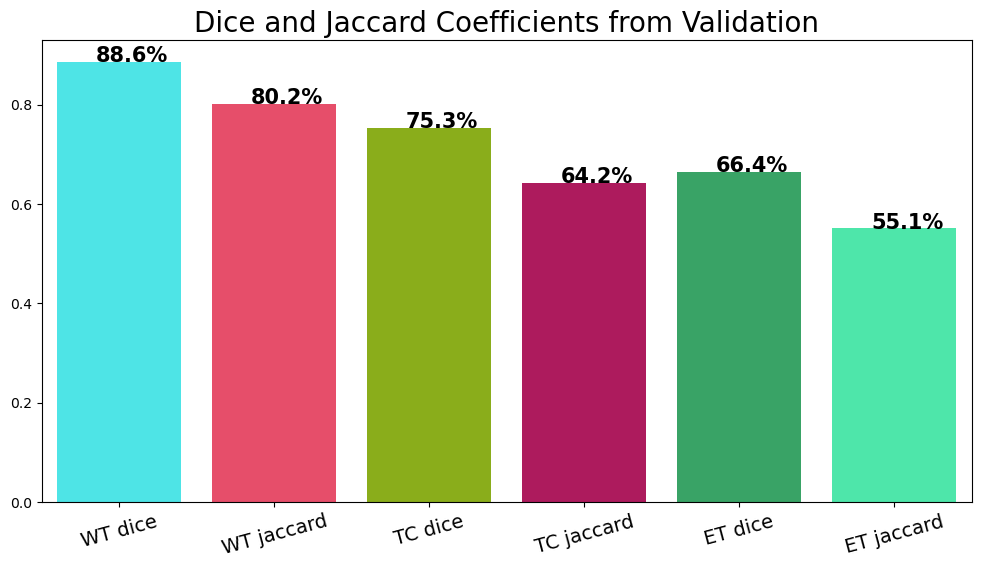

In [ ]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig(os.path.join(config.train_logs_path, "result.png"), format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig(os.path.join(config.train_logs_path, "result.svg"), format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')


## More visualization

In [ ]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            
            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()
            
            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)
            
            # only 5 pars
            if (i > 5):    
                return results
        return results

In [ ]:
# %%time
results = compute_results(
    model, val_dataloader, 0.33)

['BraTS20_Training_366']
[0. 1.]
[0. 1.]


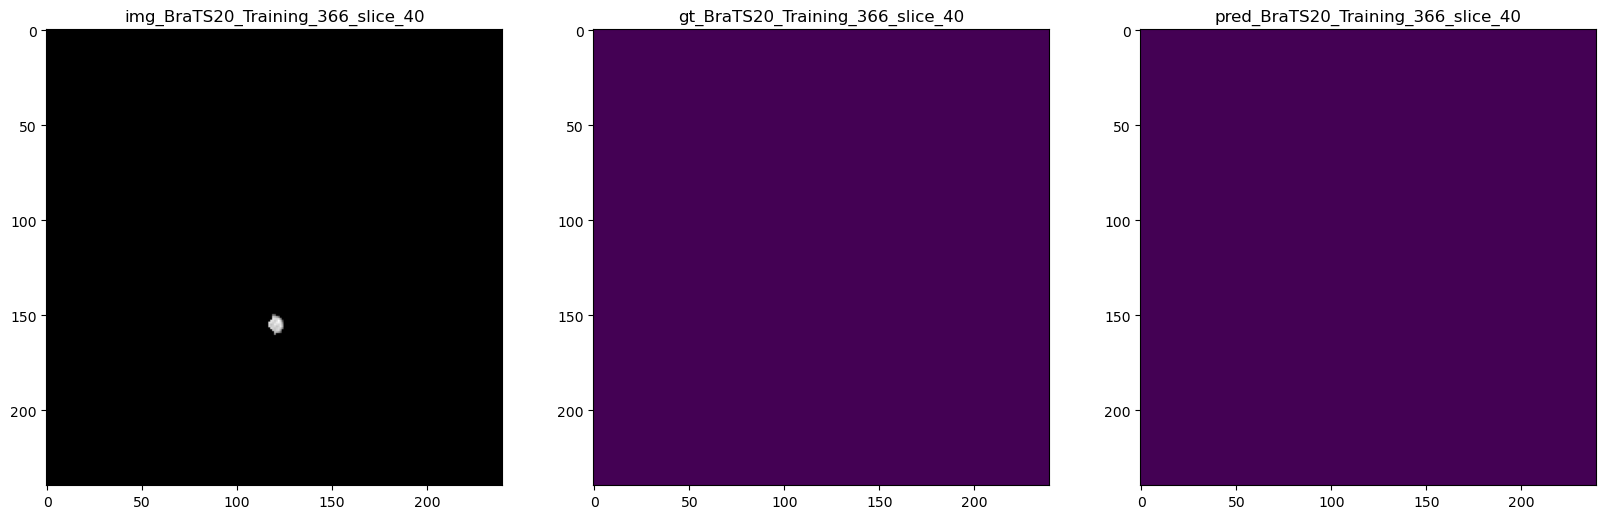

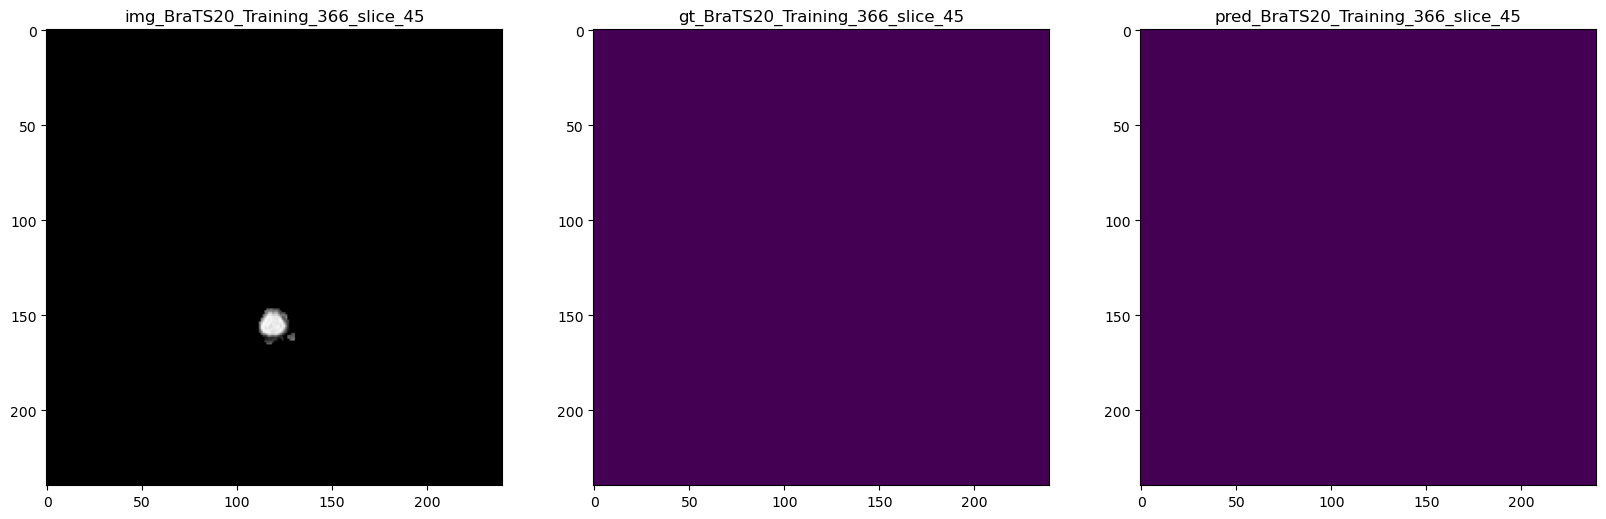

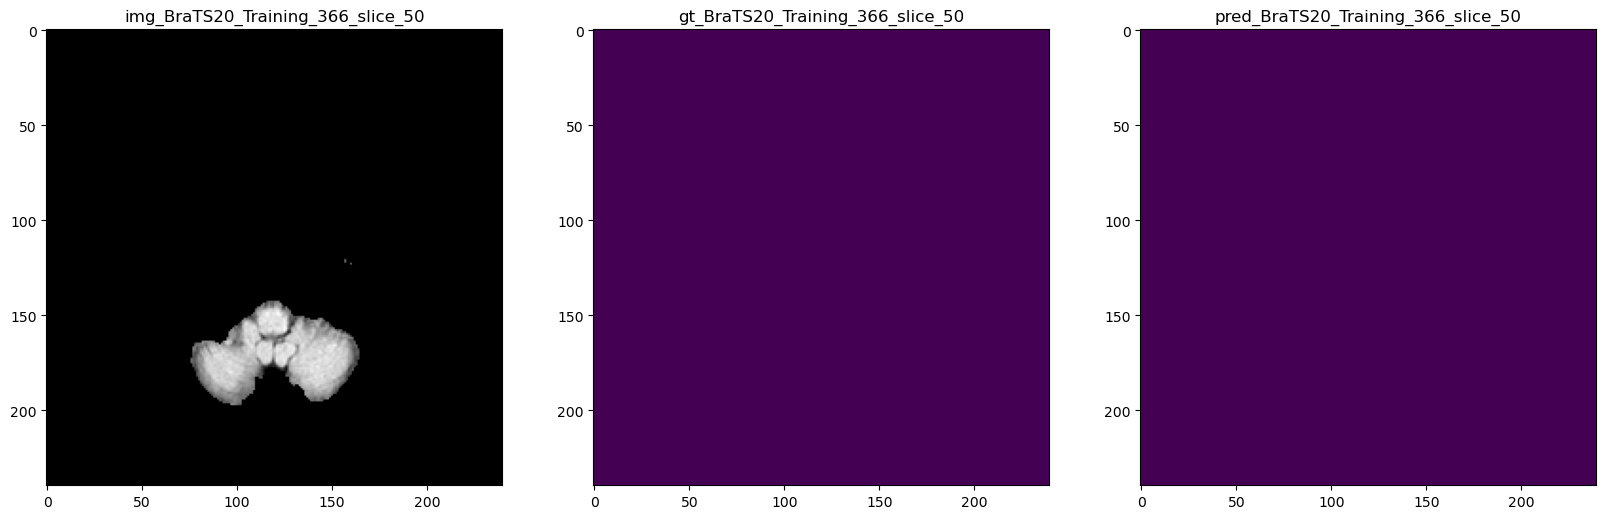

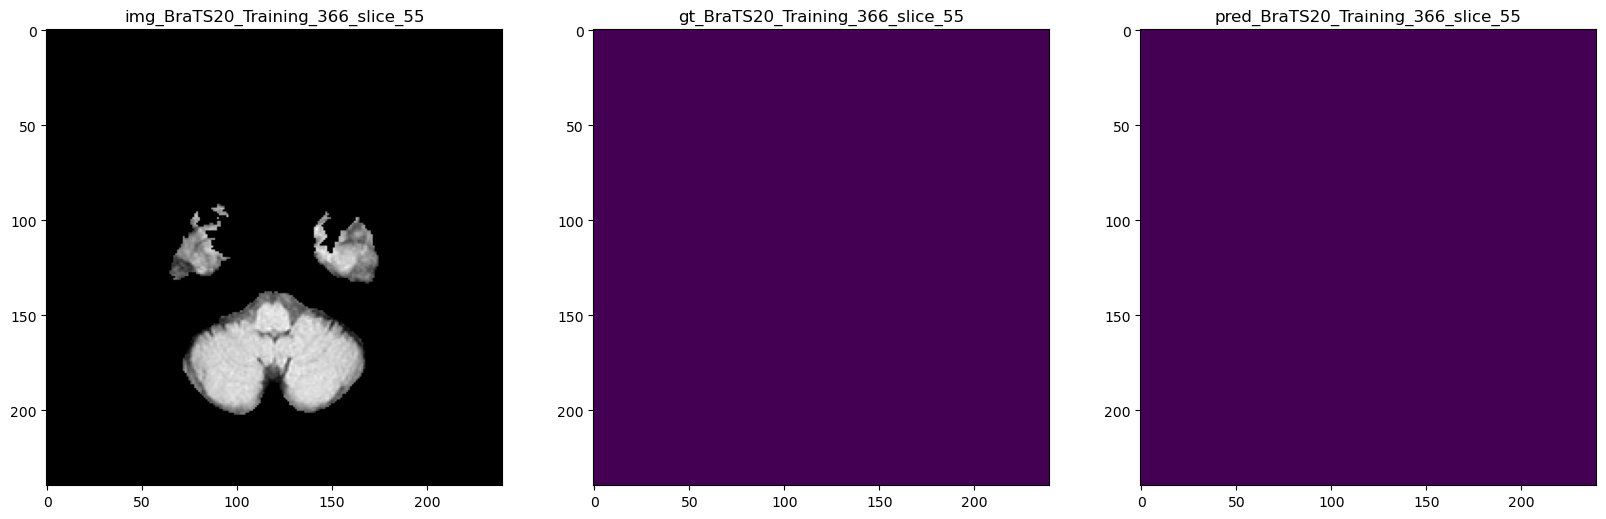

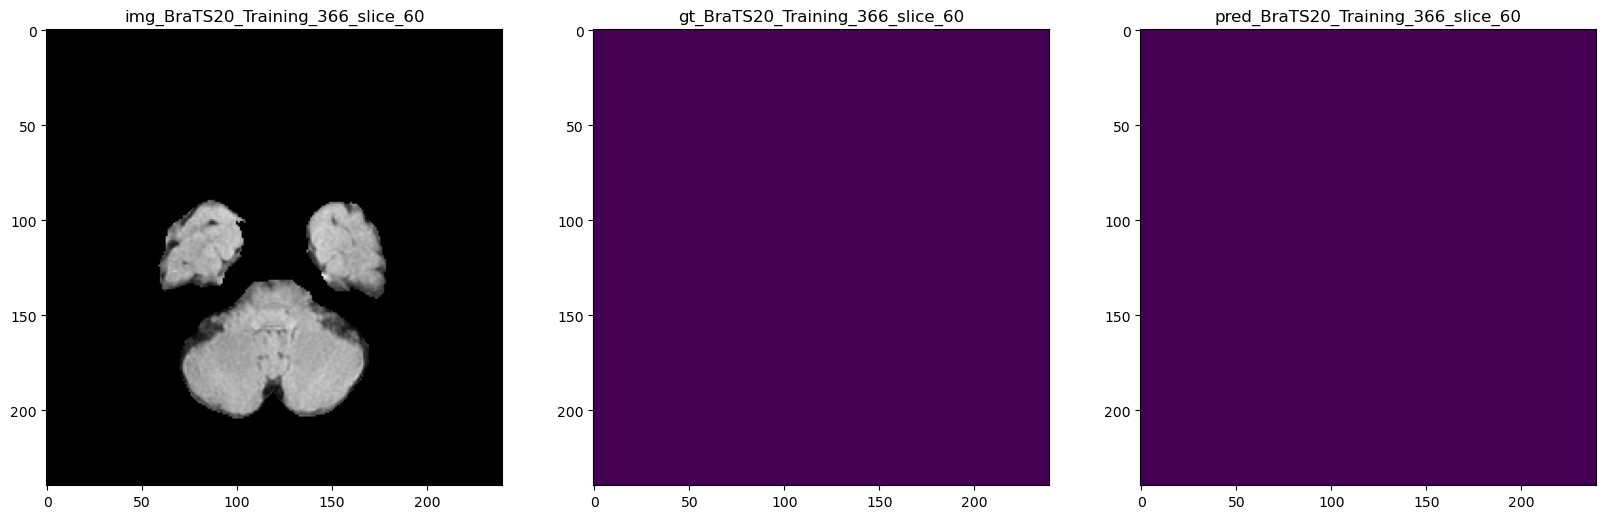

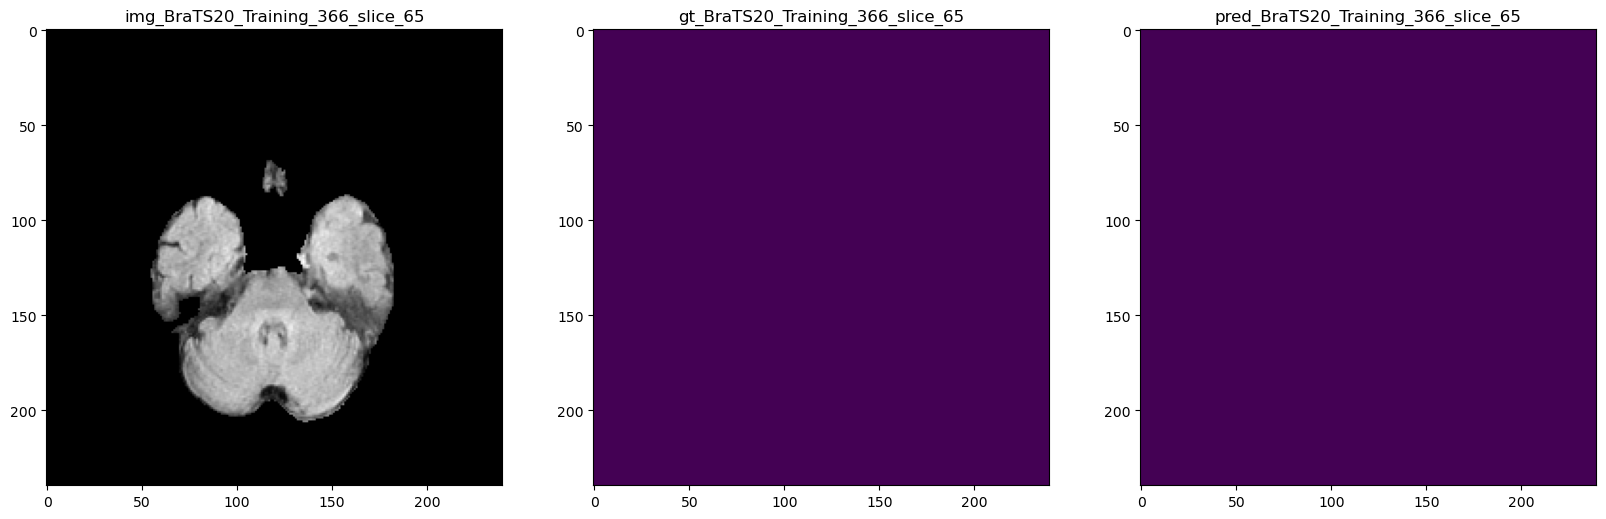

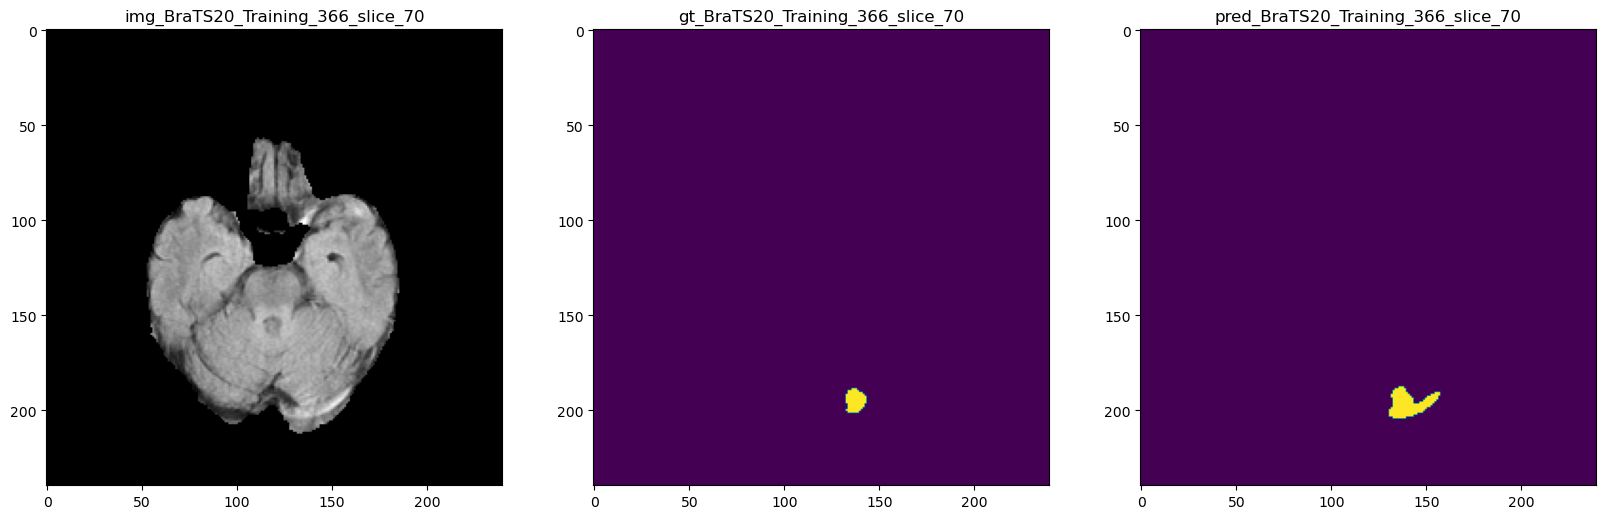

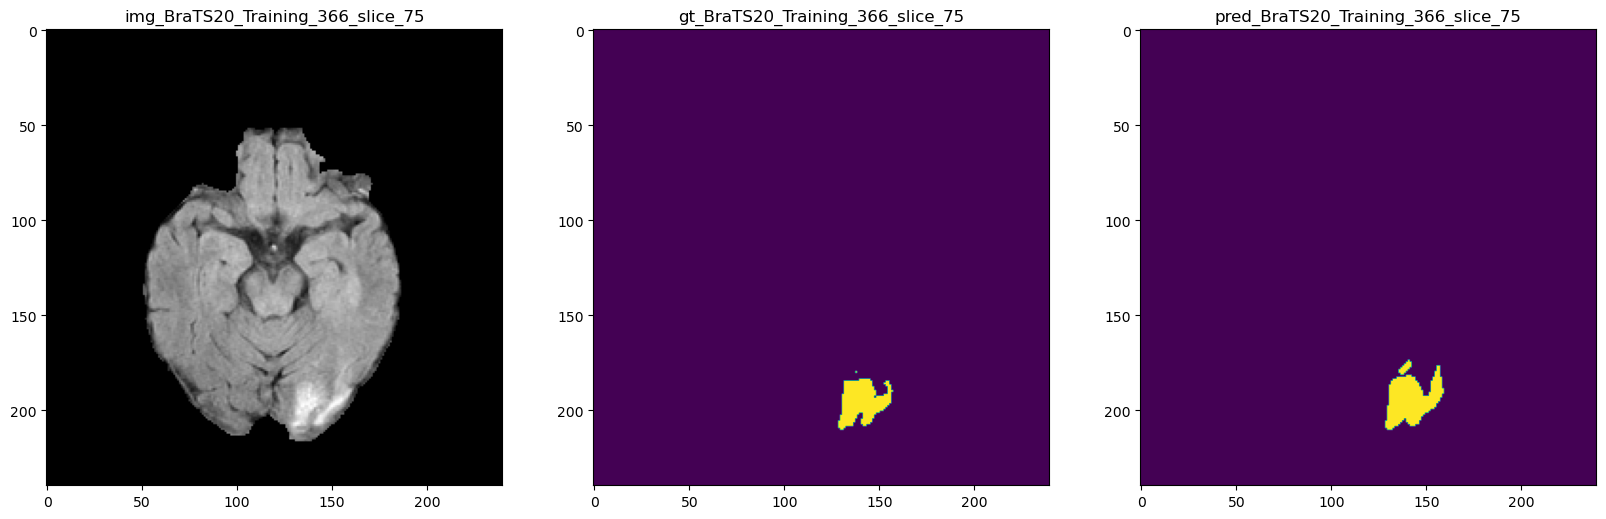

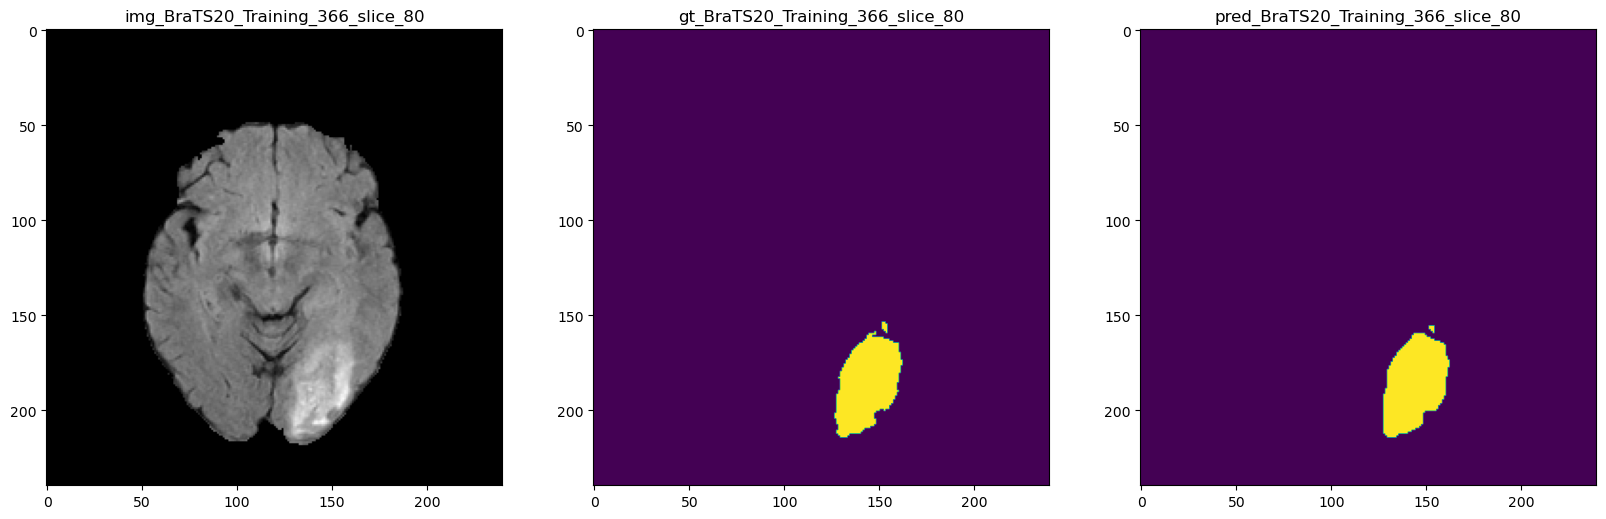

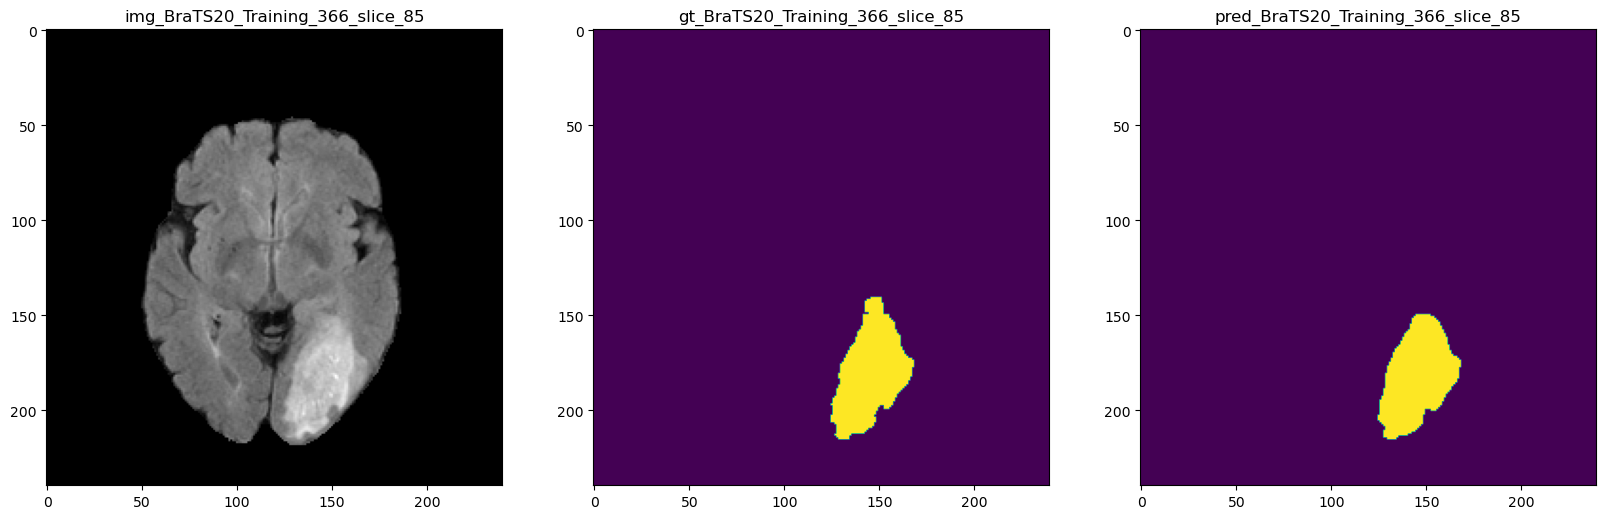

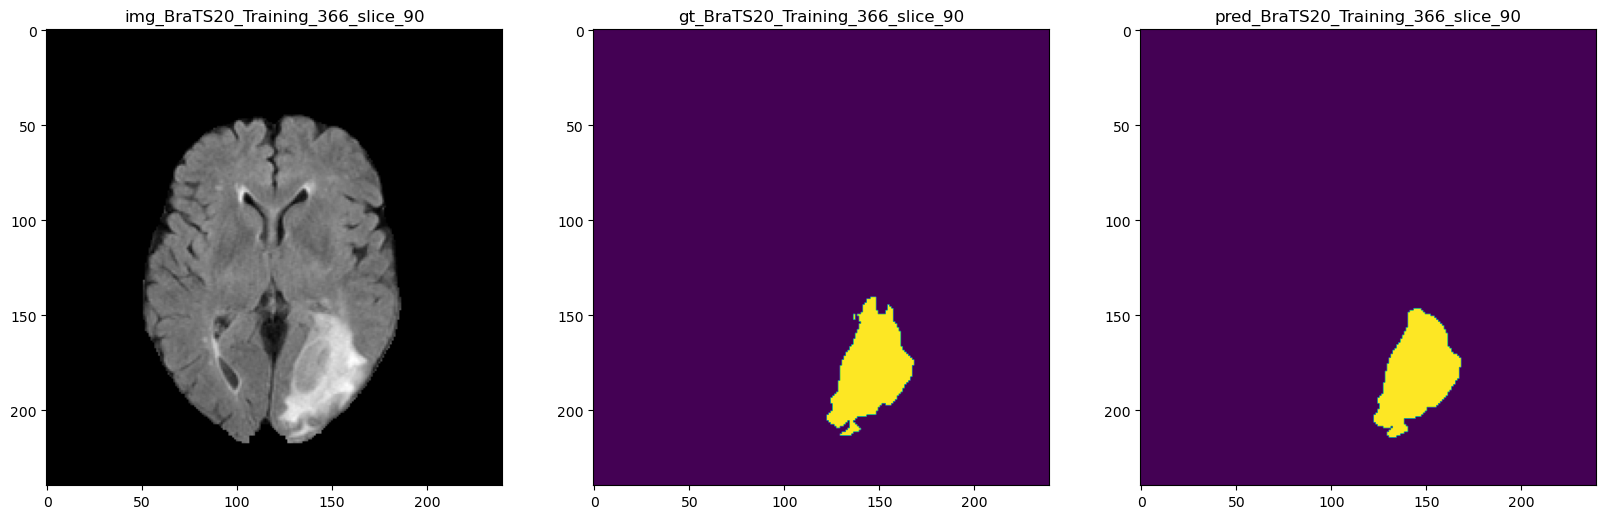

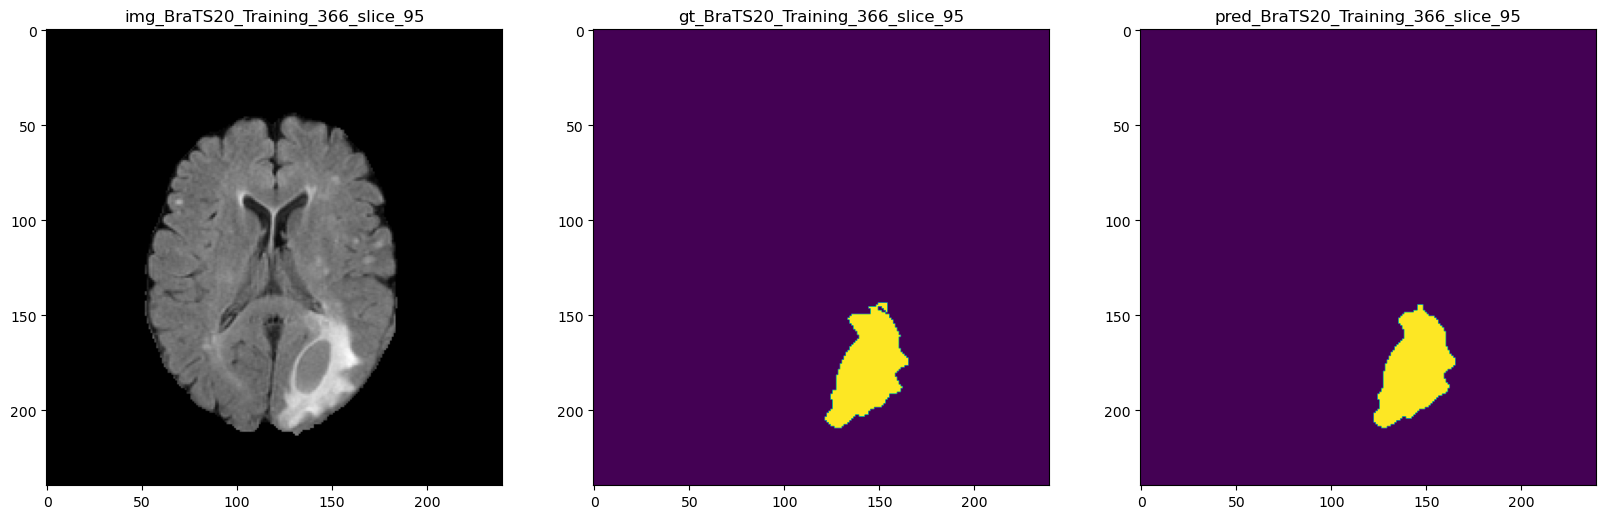

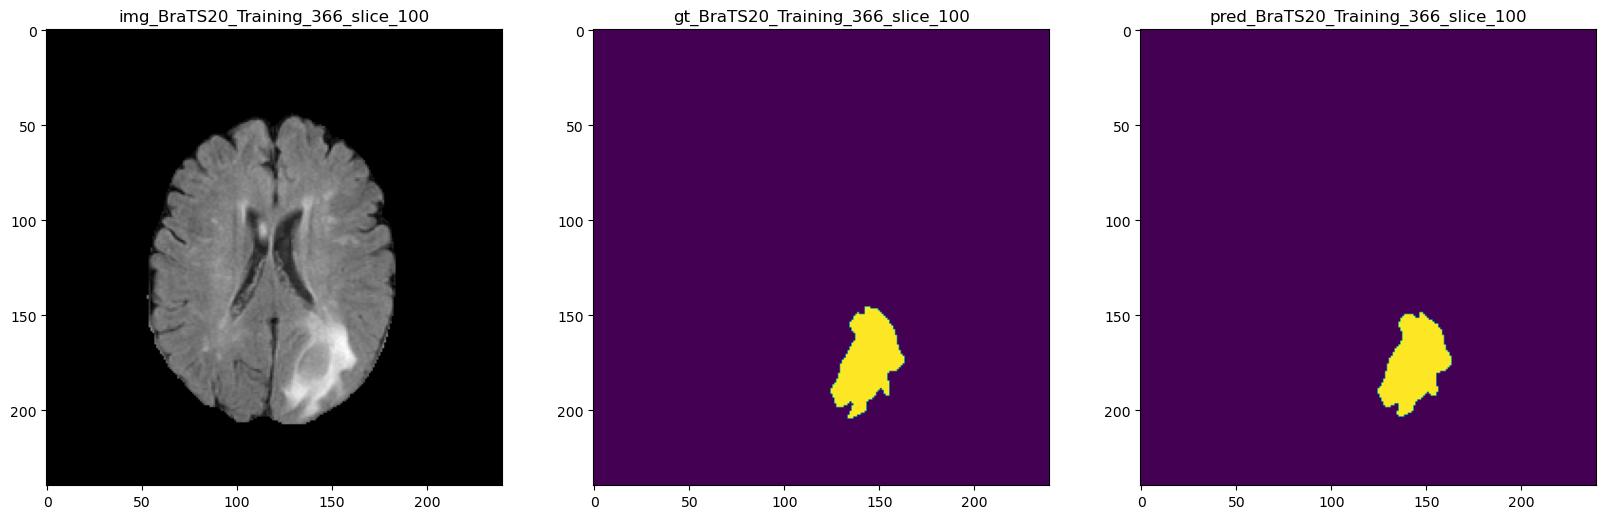

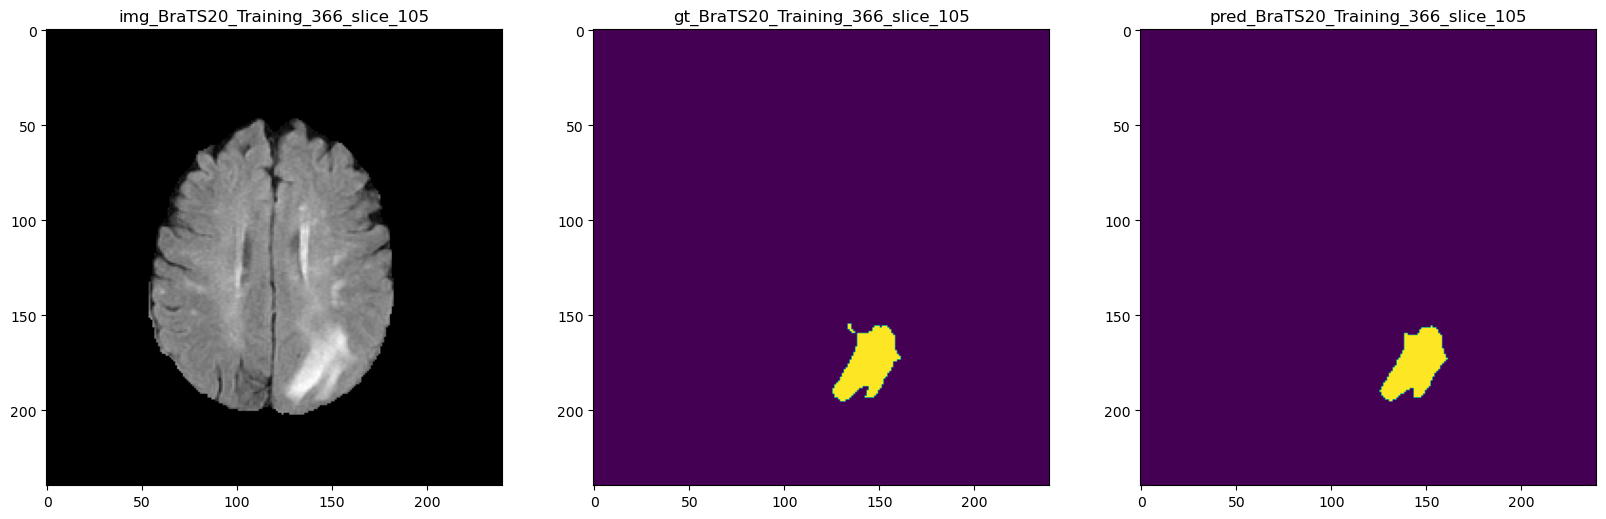

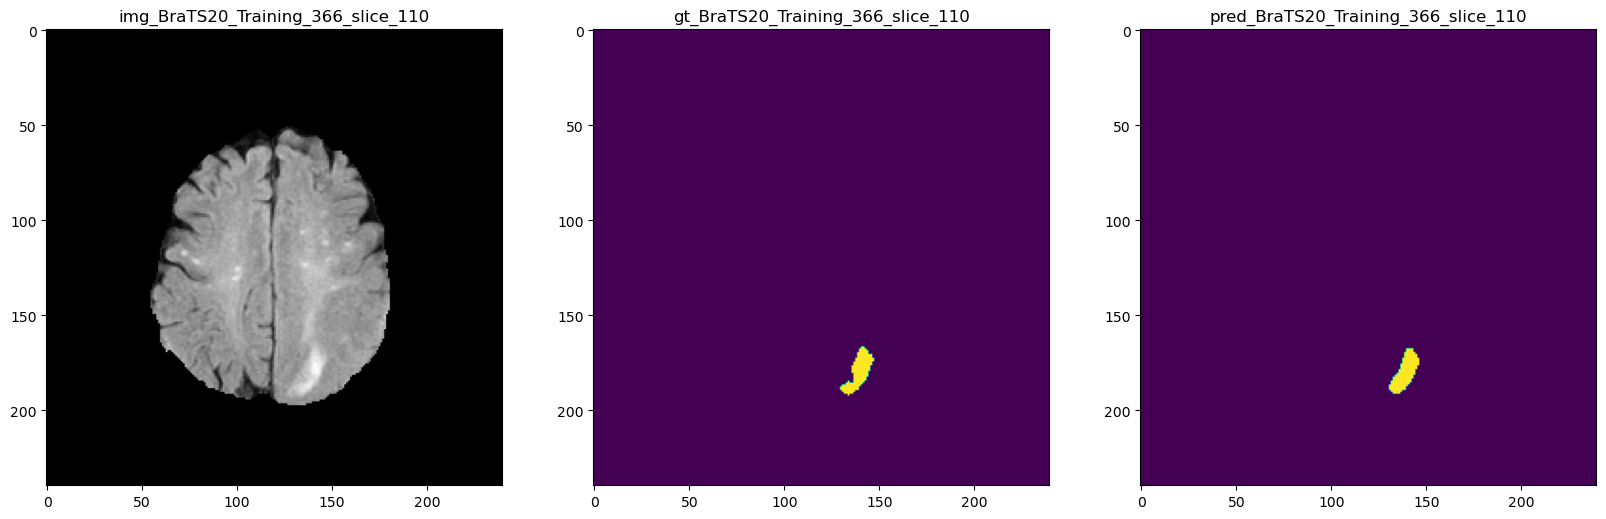

: 

In [ ]:
for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):
    
    print(id_)
    name = id_[0]
    # print(img.shape)
    # print(gt.shape)
    # print(gt.unique())
    # print(prediction.shape)
    # print(prediction.unique())
    img = img.squeeze()[0].cpu().detach().numpy()
    gt = gt.squeeze()[0].squeeze().cpu().detach().numpy()
    prediction = prediction.squeeze()[0].squeeze().cpu().detach().numpy()
    # img.reshape((240,240,155))
    # gt.reshape((240, 240, 155))
    # prediction.reshape((240, 240, 155))
    # print(np.unique(img))
    print(np.unique(gt))
    print(np.unique(prediction))
    
    
    for i in range(40,110+1,5):
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
      slice_w = i
      ax1.imshow(img[slice_w, :, :], cmap="gray")
      ax1.set_title(f'img_{name}_slice_{i}')
      ax2.imshow(gt[slice_w, :, :])
      ax2.set_title(f'gt_{name}_slice_{i}')
      ax3.imshow(prediction[slice_w, :, :])
      ax3.set_title(f'pred_{name}_slice_{i}')
      fig.savefig(os.path.join(config.train_logs_path, f"prediction_{name}_slice_{i}.png"),
                  format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
    break